# ARIMA Model

### Add project path to system path

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")
notebook_dir = os.getcwd()
parent_path=os.path.dirname(notebook_dir)

os.chdir(parent_path)

### Load Data

In [5]:
import pandas as pd
brentoil_price=pd.read_csv("data/brent_oil_price_data.csv")
brentoil_price.set_index("Date",inplace=True)

## Check Stationarity

In [6]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller



In [7]:

import seaborn as sns
import matplotlib.pyplot as plt
def stationarity(df,col):
    df["rollingMean"]=df[col].rolling(window=90).mean()
    df["rollingStd"]=df[col].rolling(window=90).std()
    result=adfuller(df[col],autolag="AIC")
    
    print(f"Test Statistics: {result[0]}")
    print(f"p-Value: {result[1]}")
    print(f"Lag used: {result[2]}")
    print(f"Number of observation: {result[2]}")
    print(f"Critical Values': {result[4]}")
    print(f"Conclusion: {'Stationary' if result[1] < 0.05 else 'Non-Stationary'}")
    
    plt.figure(figsize=(10,5))
    sns.lineplot(df,x=df.index,y=df[col])
    sns.lineplot(df,x=df.index,y=df["rollingMean"])
    sns.lineplot(df,x=df.index,y=df["rollingStd"])
    plt.legend()

Test Statistics: -1.993856011392466
p-Value: 0.2892735048934034
Lag used: 29
Number of observation: 29
Critical Values': {'1%': -3.4310783342658615, '5%': -2.861861876398633, '10%': -2.566941329781918}
Conclusion: Non-Stationary


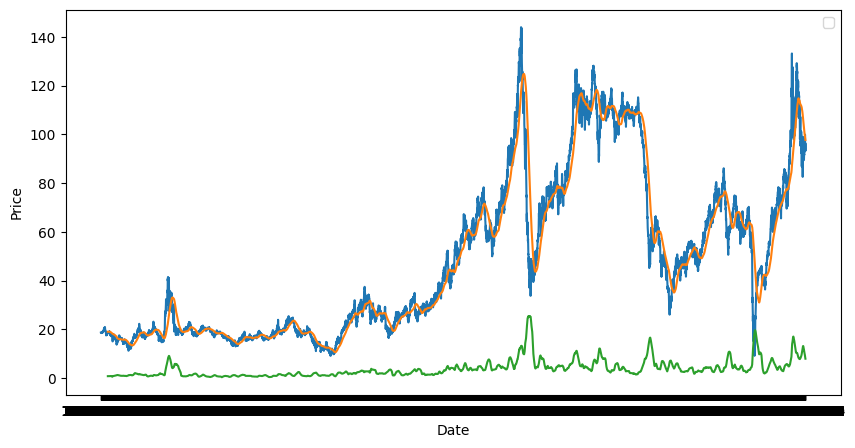

In [8]:
stationarity(brentoil_price,'Price')

### Transform to Stationary 
There are different methods to make the data stationary
* **Difference**
* **Logarithm**
* **Square Root**
* **Combination**

### Logarithmic Transformation

In [9]:
import numpy as np
brentoil_price['logPrice']=np.log(brentoil_price['Price'])

Test Statistics: -1.8088944145306611
p-Value: 0.376054890510537
Lag used: 29
Number of observation: 29


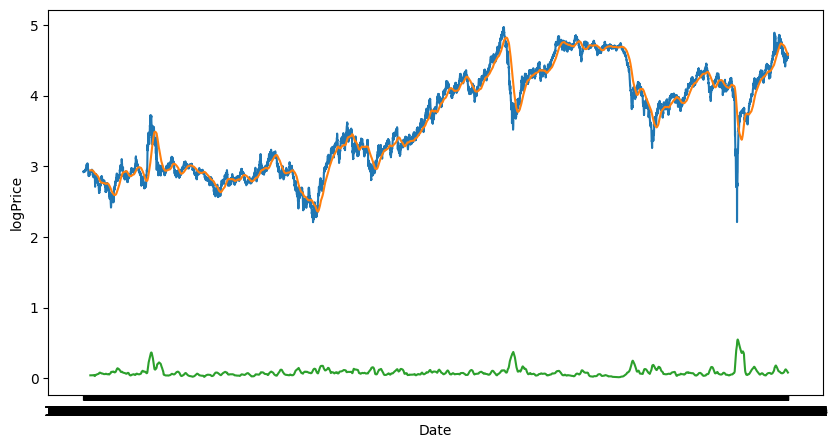

In [8]:
stationarity(brentoil_price,'logPrice')

### First Difference

In [12]:
brentoil_price['diff']=brentoil_price['Price'].diff()

C:\Users\HP\AppData\Local\Temp\ipykernel_1632\3689149644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rollingMean"]=df[col].rolling(window=90).mean()
C:\Users\HP\AppData\Local\Temp\ipykernel_1632\3689149644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rollingStd"]=df[col].rolling(window=90).std()


Test Statistics: -15.448616672762904
p-Value: 2.8033477182159807e-28
Lag used: 28
Number of observation: 28


C:\Users\HP\AppData\Local\Temp\ipykernel_1632\3689149644.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


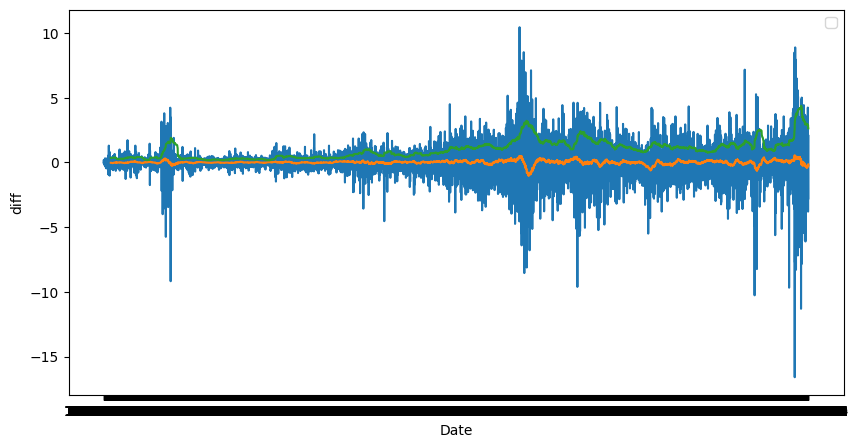

In [11]:
stationarity(brentoil_price.dropna(),'diff')

### Combination of Square root and Logarithm

In [13]:
brentoil_price['sqrtlogPrice']=np.sqrt(brentoil_price['logPrice'])

Test Statistics: -1.8425852487241057
p-Value: 0.35953350309431686
Lag used: 29
Number of observation: 29


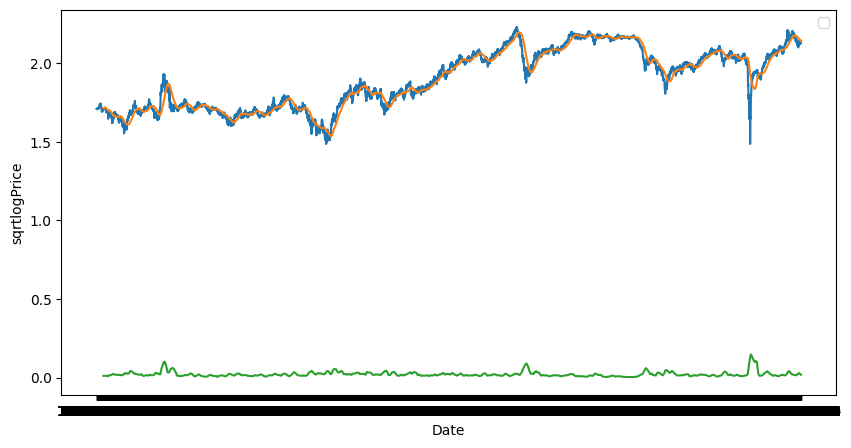

In [14]:
stationarity(brentoil_price,'sqrtlogPrice')

### Combination of Differnce, Square root and Logarithm 

In [15]:
brentoil_price['difflogsqrtPrice']=brentoil_price['sqrtlogPrice'].diff()

Test Statistics: -16.473147421521972
p-Value: 2.2732101351738417e-29
Lag used: 28
Number of observation: 28


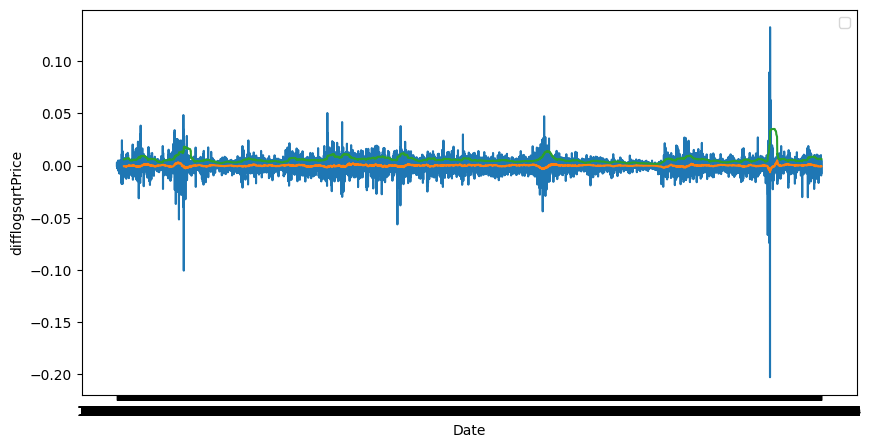

In [16]:
stationarity(brentoil_price.dropna(),'difflogsqrtPrice')

### Finfding p,d,q values

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

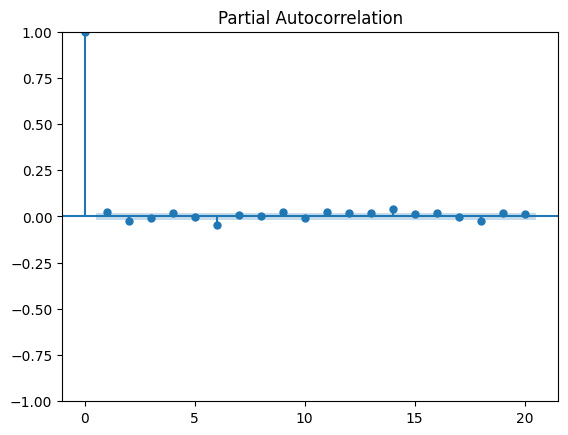

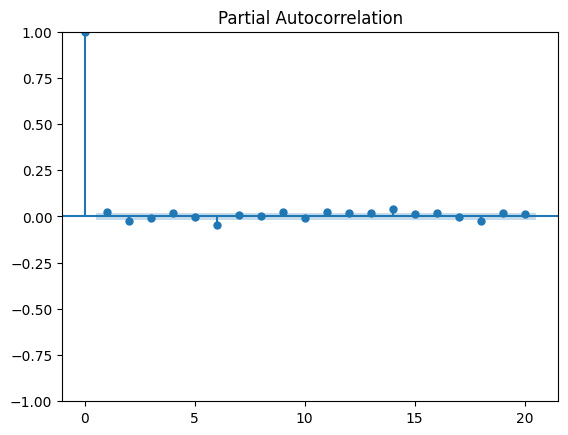

In [26]:
plot_pacf(brentoil_price['diff'].dropna(),lags=20)

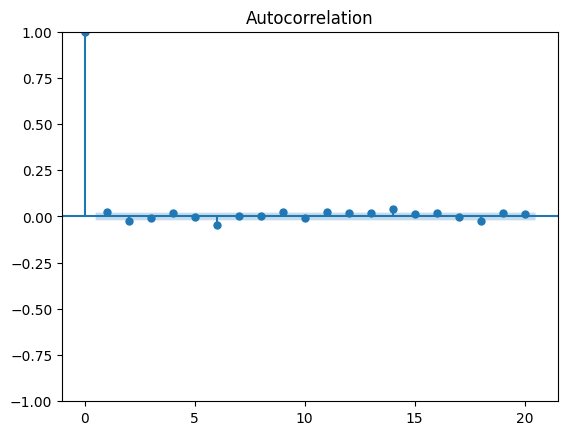

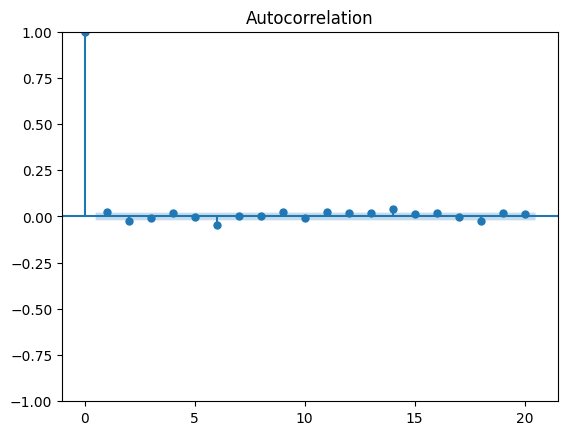

In [25]:
plot_acf(brentoil_price['diff'].dropna(),lags=20)

### Train-test split

In [11]:
train_df=brentoil_price[:round(len(brentoil_price)*0.7)]
test_df=brentoil_price[round(len(brentoil_price)*0.7):]
test_df.head()

,Price,rollingMean,rollingStd,logPrice
Date,,,,
2012-03-26,125.85,114.812556,7.354029,4.835091
2012-03-27,125.25,114.953444,7.431636,4.830312
2012-03-28,124.41,115.092444,7.490641,4.823583
2012-03-29,123.23,115.218222,7.531531,4.814053
2012-03-30,123.41,115.375556,7.553323,4.815512


In [43]:
# Based on the graphs we take p=1 , q=1 and since we use first difference (first shift) d=1
from statsmodels.tsa.arima.model import ARIMA
arima_model=ARIMA(train_df['Price'],order=(1,1,1))
model_fit=arima_model.fit()

In [44]:
# prediction=model_fit.predict(start=test_df.index[0],end=test_df.index[-1])
prediction=model_fit.forecast(steps=len(test_df))

In [45]:
prediction

6308    125.303305
6309    125.279643
6310    125.285643
6311    125.284122
6312    125.284508
           ...    
9006    125.284430
9007    125.284430
9008    125.284430
9009    125.284430
9010    125.284430
Name: predicted_mean, Length: 2703, dtype: float64

In [46]:
predicted_Price=pd.Series(prediction,name='predicted_Price')
actual_vs_prediction=test_df
actual_vs_prediction['predicted_Price']=predicted_Price.values

## Evaluation

Mean Absolute Error (MAE): 52.09192940609662
Mean Squared Error (MSE): 3394.385227475103
Root Mean Squared Error (RMSE): 58.26135277759265
R Square Score (r2_score): 58.26135277759265
Mean Absolute Percentage Error (MAPE): 98.01071091161106 %


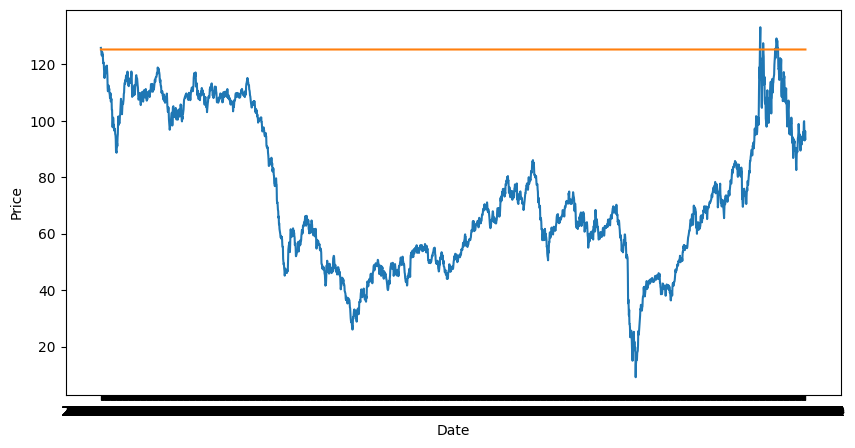

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,r2_score
import numpy as np

plt.figure(figsize=(10,5))
sns.lineplot(actual_vs_prediction,x=actual_vs_prediction.index,y=actual_vs_prediction['Price'])
sns.lineplot(actual_vs_prediction,x=actual_vs_prediction.index,y=actual_vs_prediction['predicted_Price'])

# Assuming y_true and y_pred are your true and predicted values
y_true = actual_vs_prediction['Price']  # Replace with actual values
y_pred = actual_vs_prediction['predicted_Price'] # Replace with actual predicted values

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2_score=r2_score(y_true,y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE as a percentage

# Print metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R Square Score (r2_score):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
